# Libraries

In [1]:
# for local import
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

In [2]:
# for working with data
import pandas as pd
import numpy as np
import scipy.sparse

# for visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# for preprocessing
from src.preprocessing import BasicTextCleaning
from src.exploration import check_balance, distribution_barplot, distribution_otherbased
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from gensim.models import Word2Vec
from nltk import ngrams

# for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# for evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score

# for timing
import time

# Load Data

In [3]:
osf = pd.read_csv("../../data/fake_reviews_dataset.csv")
print("Shape of OFS: ", osf.shape)
# osf.head()
osf

Shape of OFS:  (40432, 4)


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...


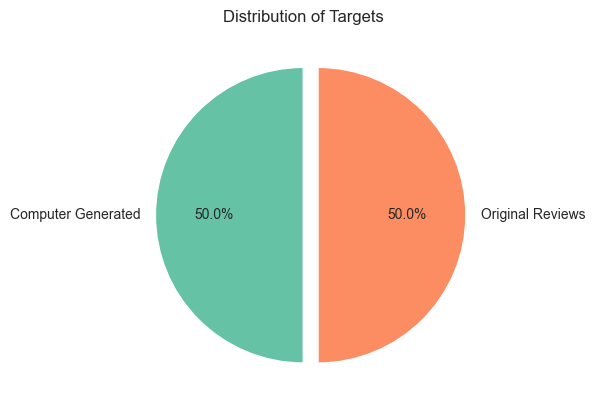

In [4]:
check_balance(data=osf, target="label")

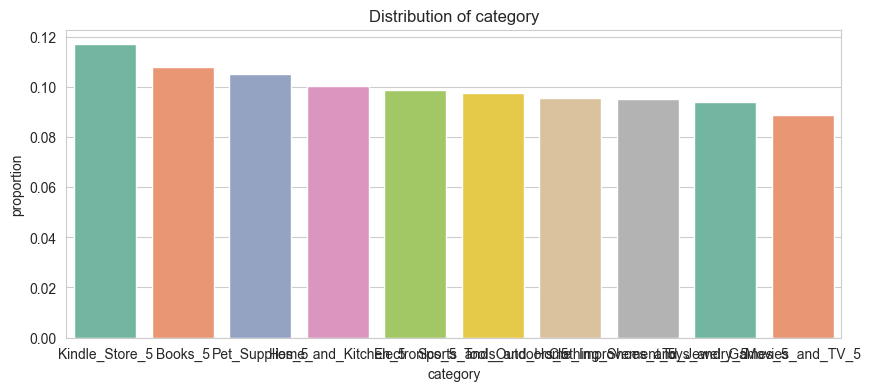

In [5]:
plt.figure(figsize=(10, 4))
distribution_barplot(data=osf, feature="category")

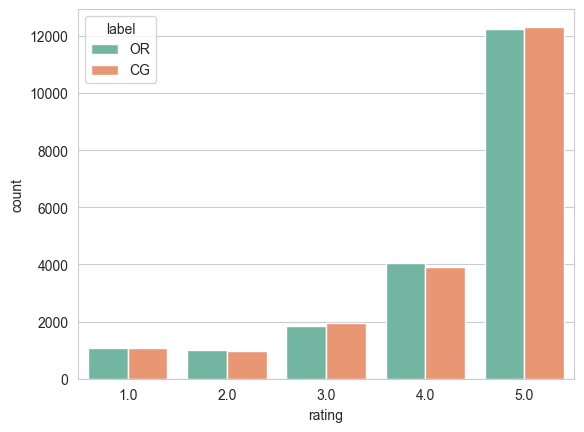

In [6]:
distribution_otherbased(data=osf, dist_feature="label", base_feature="rating", normalize=False)

# Preprocessing

### Basic Text Cleaning

In [7]:
cleaner = BasicTextCleaning()

In [8]:
try:
    osf_cleaned = pd.read_csv("../../data/cleaned/osf_cleaned.csv")
    osf_cleaned = osf_cleaned.replace(np.nan, '')
except:
    osf_cleaned = pd.DataFrame()
    osf_cleaned['length'] = osf['text_'].apply(lambda x: len(x))
    osf_cleaned['texts'] = cleaner.text_cleaning(osf['text_'])

    ordinal = OrdinalEncoder(categories=[['OR', 'CG']], dtype=int)
    osf_cleaned['labels'] = ordinal.fit_transform(osf[['label']])
    osf_cleaned.to_csv("../../data/cleaned/osf_cleaned.csv", index=False)

In [9]:
from nltk import ngrams

class AvgWord2Vec:
    def __init__(self, vector_size=300, min_count=1, sg=1, ngram_range=(1, 1), window=5, epochs=5, seed=42,
                 quiet=True):
        self.w2v = Word2Vec(vector_size=vector_size, min_count=min_count, sg=sg,
                            window=window, workers=4, seed=seed, epochs=epochs)
        self.min_count = min_count
        self.sg = sg
        self.window = window
        self.seed = seed
        self.vsize = vector_size
        self.epochs = epochs

        self.ngrams = np.arange(ngram_range[0], ngram_range[1]+1, 1)
        self.raw = None
        self.corpus = None
        self.vocabulary_ = None
        self.quiet = quiet

    def _create_ngrams(self, n, X):
        phrases = []
        for sent in X:
            words = sent.split()
            if len(words) >= n:  # Check if words list is not empty
                ngram_list = list(ngrams(words, n))
                phrases.append([" ".join(word) for word in ngram_list])
            else:
                phrases.append([])
        return phrases
    
    def _create_corpus(self, X, update_train=False):
        ngrams_phrases = {}
        for n in self.ngrams:
            phrases = self._create_ngrams(n, X)
            ngrams_phrases[f"{n}"] = phrases
        data = []
        corpus = []
        for n in ngrams_phrases.values():
            if len(data)==0:
                data = n
            data = [data[i] + n[i] for i in range(len(data))]
            corpus.extend(n)
        if update_train:
            self.corpus = corpus
        return data, corpus
    
    def _avg_sentence(self, sentences):
        w2v_model = self.w2v
        avg_sentences = []
        for sentence in sentences:
            if len(sentence)!=0:
                avg_sentence = np.mean([w2v_model.wv.get_vector(word) for word in sentence
                                        if word in w2v_model.wv.key_to_index], axis=0)
            else:
                avg_sentence = np.zeros(w2v_model.vector_size)
            avg_sentences.append(avg_sentence)
        return np.array(avg_sentences)

    def fit(self, X):
        self.w2v = Word2Vec(vector_size=self.vsize, min_count=self.min_count, sg=self.sg,
                            window=self.window, workers=4, seed=self.seed, epochs=self.epochs)
        self.raw = list(X)
        
        start = time.time()
        corpus = self._create_corpus(update_train=True, X=X)[1]
        durations = time.time() - start
        if not self.quiet:
            print(f'Create corpus: Done in {int(durations//60)}m{int(durations%60)}s')
        
        start = time.time()
        self.w2v.build_vocab(corpus)
        durations = time.time() - start
        if not self.quiet:
            print(f'Build vocab: Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        self.w2v.train(corpus, total_examples=self.w2v.corpus_count, epochs=self.w2v.epochs)
        durations = time.time() - start
        if not self.quiet:
            print(f'Training : Done in {int(durations//60)}m{int(durations%60)}s')

        self.vocabulary_ = self.w2v.wv.key_to_index

    def fit_transform(self, X):
        self.w2v = Word2Vec(vector_size=self.vsize, min_count=self.min_count, sg=self.sg,
                            window=self.window, workers=4, seed=self.seed, epochs=self.epochs)
        self.raw = list(X)

        start = time.time()
        data, corpus = self._create_corpus(update_train=True, X=X)
        durations = time.time() - start
        if not self.quiet:
            print(f'Create corpus: Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        self.w2v.build_vocab(corpus)
        durations = time.time() - start
        if not self.quiet:
            print(f'Build vocab: Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        self.w2v.train(corpus, total_examples=self.w2v.corpus_count, epochs=self.w2v.epochs)
        durations = time.time() - start
        if not self.quiet:
            print(f'Training : Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        avg_sents = self._avg_sentence(data)
        durations = time.time() - start
        if not self.quiet:
            print(f'Average : Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        avg_sents_sprs = scipy.sparse.csr_matrix(avg_sents)
        durations = time.time() - start
        if not self.quiet:
            print(f'Sparse : Done in {int(durations//60)}m{int(durations%60)}s')

        return avg_sents_sprs
        
    def transform(self, X):
        start = time.time()
        data = self._create_corpus(update_train=False, X=X)[0]
        durations = time.time() - start
        if not self.quiet:
            print(f'Create corpus: Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        avg_sents = self._avg_sentence(data)
        durations = time.time() - start
        if not self.quiet:
            print(f'Average : Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        avg_sents_sprs = scipy.sparse.csr_matrix(avg_sents)
        durations = time.time() - start
        if not self.quiet:
            print(f'Sparse : Done in {int(durations//60)}m{int(durations%60)}s')

        return avg_sents_sprs
    
    def get_feature_names_out(self):
        columns = np.array([f'component_{i+1}' for i in range(self.vsize)])
        return columns

In [10]:
def avg_word2vec(sentences, w2v_model):
    avg_sentences = []
    for sentence in sentences:
        if sentence:
            avg_sentence = np.mean([w2v_model.wv.get_vector(word) for word in sentence if word in w2v_model.wv.key_to_index], axis=0)
        else:
            avg_sentence = np.zeros(w2v_model.vector_size)
        avg_sentences.append(avg_sentence)
    return np.array(avg_sentences)

def text_extractor(X_train, X_test, extractor):
    X_train = extractor.fit_transform(X_train).toarray()
    X_test = extractor.transform(X_test).toarray()
    try:
        X_train = pd.DataFrame(X_train, columns=extractor.get_feature_names_out())
        X_test = pd.DataFrame(X_test, columns=extractor.get_feature_names_out())
    except:
        X_train = pd.DataFrame(X_train, columns=[f"component_{i+1}" for i in range(X_train.shape[1])])
        X_test = pd.DataFrame(X_test, columns=[f"component_{i+1}" for i in range(X_test.shape[1])])  

    return X_train, X_test

def feature_selection(X_train, X_test, selector):
    X_train = selector.fit_transform(X_train)
    X_test = selector.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=selector.get_feature_names_out())
    X_test = pd.DataFrame(X_test, columns=selector.get_feature_names_out())
    
    return X_train, X_test

In [11]:
def modelling(model, X_train, y_train, X_test, probability=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if probability:
        y_pred_proba = model.predict_proba(X_test)
        return y_pred, y_pred_proba
    return y_pred

def evaluation(y_true, y_pred, y_pred_prob, scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc']):
    scores = {'accuracy': accuracy_score,
              'f1': f1_score,
              'recall': recall_score,
              'precision': precision_score,
              'roc_auc': roc_auc_score}
    
    result = {}
    for method in scoring:
        if method == 'roc_auc':
            result[method] = scores[method](y_true, y_pred_prob.T[1])
        else:
            result[method] = scores[method](y_true, y_pred)

    return result

In [12]:
import time

def cross_validation(data, extractor=None, model=None, selector=None, length_scaler=None,
                     scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc'], cv=5,
                     avg_output=True, quiet=True, data_list=None):
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=42)
    indices_folds = kfolds.split(data.iloc[:, :-1], data.iloc[:, -1])
    scores = {method: [] for method in scoring}
    round_num = 1
    fold = 0

    for train_indices, test_indices in indices_folds:

        train_set, test_set = data.iloc[train_indices, :-1], data.iloc[test_indices, :-1]
        y_train, y_test = data.iloc[train_indices, -1], data.iloc[test_indices, -1]

        if not quiet:
            print(f"round {round_num}:")

        train_set, test_set = data.iloc[train_indices, :-1], data.iloc[test_indices, :-1]
        y_train, y_test = data.iloc[train_indices, -1], data.iloc[test_indices, -1]

        if extractor is not None:
            start = time.time()
            X_train, X_test = text_extractor(X_train=train_set['texts'], X_test=test_set['texts'], extractor=extractor)
            durations = time.time() - start
            if not quiet:
                print(f'\tText extraction: Done in {int(durations//60)}m{int(durations%60)}s')
        else:
            X_train, X_test = data_list[fold][0], data_list[fold][1]
            fold += 1

        # start = time.time()
        # X_train, X_test = text_extractor(X_train=train_set['texts'], X_test=test_set['texts'], extractor=extractor)
        # durations = time.time() - start
        # if not quiet:
        #     print(f"round {round}:")
        #     print(f'\tText extraction: Done in {int(durations//60)}m{int(durations%60)}s')

        if length_scaler is not None:
            start = time.time()
            X_train['length'] = length_scaler.fit_transform(train_set[['length']])
            X_test['length'] = length_scaler.transform(test_set[['length']])
            durations = time.time() - start
            if not quiet:
                print(f'\tLength scale: Done in {int(durations//60)}m{int(durations%60)}s')
        
        if selector is not None:
            start = time.time()
            X_train, X_test = feature_selection(X_train, X_test, selector)
            durations = time.time() - start
            if not quiet:
                print(f'\tDimensionality reduction: Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        y_pred, y_pred_prob = modelling(model, X_train, y_train, X_test)
        durations = time.time() - start
        if not quiet:
            print(f'\tModelling: Done in {int(durations//60)}m{int(durations%60)}s')

        start = time.time()
        result = evaluation(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_prob, scoring=scoring)
        for method in scoring:
            scores[method].append(result[method])
        durations = time.time() - start
        if not quiet:
            print(f'\tEvaluation: Done in {int(durations//60)}m{int(durations%60)}s', end="\n\n")

        round_num += 1
        
    if avg_output:
        avg_scores = {key: np.mean(values) for key, values in scores.items()}

    return avg_scores

In [13]:
# import time

# def multi_models_cross_validation(data, extractor, models=None, selector=None, length_scaler=None,
#                                   scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc'], cv=5, quiet=True):
#     kfolds = KFold(n_splits=cv, shuffle=True, random_state=42)
#     indices = kfolds.split(data.iloc[:, :-1], data.iloc[:, -1])
#     output = {model: {score: [] for score in scoring} for model in models.keys()}
#     round = 1

#     for train_indices, test_indices in indices:
#         if not quiet:
#           print(f"round {round}:")

#         train_set, test_set = data.iloc[train_indices, :-1], data.iloc[test_indices, :-1]
#         y_train, y_test = data.iloc[train_indices, -1], data.iloc[test_indices, -1]

#         start = time.time()
#         X_train, X_test = text_extractor(X_train=train_set['texts'], X_test=test_set['texts'], extractor=extractor)
#         durations = time.time() - start
#         if not quiet:
#             print(f'\tText extraction: Done in {int(durations//60)}m{int(durations%60)}s')

#         start = time.time()
#         if length_scaler is not None:
#             X_train['length'] = length_scaler.fit_transform(train_set[['length']])
#             X_test['length'] = length_scaler.transform(test_set[['length']])
#         durations = time.time() - start
#         if not quiet:
#             print(f'\tLength scale: Done in {int(durations//60)}m{int(durations%60)}s')

#         start = time.time()
#         if selector is not None:
#             X_train, X_test = feature_selection(X_train, X_test, selector)
#         durations = time.time() - start
#         if not quiet:
#             print(f'\tDimensionality reduction: Done in {int(durations//60)}m{int(durations%60)}s')

#         for key, model in models.items():
#             start = time.time()
#             y_pred, y_pred_prob = modelling(model, X_train, y_train, X_test)
#             durations = time.time() - start
#             if not quiet:
#                 print(f'\t{key} - Modelling: Done in {int(durations//60)}m{int(durations%60)}s')

#             start = time.time()
#             result = evaluation(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_prob, scoring=scoring)
#             for method in scoring:
#                 output[key][method].append(result[method])
#             durations = time.time() - start
#             if not quiet:
#                 print(f'\tEvaluation: Done in {int(durations//60)}m{int(durations%60)}s')
#         if not quiet:
#             print()
#         round += 1

#     for model_name, model_scores in output.items():
#         output[model_name] = {key: np.mean(values) for key, values in model_scores.items()}

#     return output

In [14]:
import time

def multi_cross_validation(data, extractor, models=None, selector=None, length_scalers=None,
                           scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc'], cv=5, quiet=True,
                           data_list=None):
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=42)
    indices = kfolds.split(data.iloc[:, :-1], data.iloc[:, -1])
    output = {model: {score: [] for score in scoring} for model in models.keys()}
    output = {length: {model: {score: [] for score in scoring} for model in models.keys()} for length in length_scalers}
    round_num = 1
    fold = 0

    for train_indices, test_indices in indices:
        if not quiet:
            print(f"round {round_num}:")

        train_set, test_set = data.iloc[train_indices, :-1], data.iloc[test_indices, :-1]
        y_train, y_test = data.iloc[train_indices, -1], data.iloc[test_indices, -1]

        if extractor is not None:
            start = time.time()
            text_train, text_test = text_extractor(X_train=train_set['texts'], X_test=test_set['texts'], extractor=extractor)
            durations = time.time() - start
            if not quiet:
                print(f'\tText extraction: Done in {int(durations//60)}m{int(durations%60)}s')
        else:
            text_train, text_test = data_list[fold][0], data_list[fold][1]
            fold += 1
        
        for length_scaler_name, length_scaler in length_scalers.items():
            X_train, X_test = text_train, text_test
            if length_scaler is not None:
                start = time.time()
                X_train['length'] = length_scaler.fit_transform(train_set[['length']])
                X_test['length'] = length_scaler.transform(test_set[['length']])
                durations = time.time() - start
                if not quiet:
                    print(f'\tLength scaled - {length_scaler_name}: Done in {int(durations//60)}m{int(durations%60)}s')

            if selector is not None:
                start = time.time()
                X_train, X_test = feature_selection(X_train, X_test, selector)
                durations = time.time() - start
                if not quiet:
                    print(f'\tDimensionality reduction: Done in {int(durations//60)}m{int(durations%60)}s')

            for model_name, model in models.items():
                start = time.time()
                y_pred, y_pred_prob = modelling(model, X_train, y_train, X_test)
                durations = time.time() - start
                if not quiet:
                    print(f'\t{model_name} - Modelling: Done in {int(durations//60)}m{int(durations%60)}s')

                start = time.time()
                result = evaluation(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_prob, scoring=scoring)
                for method in scoring:
                    output[length_scaler_name][model_name][method].append(result[method])
                durations = time.time() - start
                if not quiet:
                    print(f'\tEvaluation: Done in {int(durations//60)}m{int(durations%60)}s')
        if not quiet:
            print()
        round_num += 1

    for length, result in output.items():
        for model_name, model_scores in result.items():
            output[length][model_name] = {key: np.mean(values) for key, values in model_scores.items()}

    return output

In [15]:
# extractor = AvgWord2Vec(window=10, vector_size=300, seed=42, sg=1, ngram_range=(1, 1), epochs=15)
# model = LogisticRegression(max_iter=1000, class_weight="balanced")
# # model = SVC(probability=True, class_weight='balanced')
# # extractor = TfidfVectorizer(min_df=0.001, ngram_range=(1, 1))
# # model = SVC()

# cross_validation(data=osf_cleaned, length_scaler=None,
#                  model=model, extractor=extractor, quiet=False)

In [16]:
def preprocessing(X_train, X_test, extractor, length_scaler=None, selector=None, quiet=True):
    start = time.time()
    X_train_final, X_test_final = text_extractor(X_train=X_train['texts'], X_test=X_train['texts'],
                                                 extractor=extractor)
    durations = time.time() - start
    if not quiet:
        print(f'Text extraction: Done in {int(durations//60)}m{int(durations%60)}s')

    start = time.time()
    if length_scaler is not None:
        X_train_final['length'] = length_scaler.fit_transform(X_train[['length']])
        X_test_final['length'] = length_scaler.transform(X_test[['length']])
    durations = time.time() - start
    if not quiet:
        print(f'Length scale: Done in {int(durations//60)}m{int(durations%60)}s')

    start = time.time()
    if selector is not None:
        X_train_final, X_test_final = feature_selection(X_train_final, X_test_final, selector)
    durations = time.time() - start
    if not quiet:
        print(f'Dimensionality reduction: Done in {int(durations//60)}m{int(durations%60)}s')

    return X_train_final, X_test_final

In [17]:
data = osf_cleaned.copy()
data

,length,texts,labels
0,75,love well made sturdi comfort love pretti,1
1,80,love great upgrad origin mine coupl year,1
2,67,pillow save back love look feel pillow,1
3,81,miss inform use great product price,1
4,85,nice set good qualiti set two month,1
...,...,...,...
40427,1694,read review say bra ran small order two band c...,0
40428,1304,sure exactli would littl larg small size think...,1
40429,1987,wear hood wear hood wear jacket without hood 3...,0
40430,1301,like noth dress reason gave 4 star order size ...,1


In [18]:
saved_file = False

if saved_file:
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    indices = kfolds.split(data)
    fold = 1
    for train_indices, test_indices in indices:
        train_set, test_set = data.iloc[train_indices, :-1], data.iloc[test_indices, :-1]
        y_train, y_test = data.iloc[train_indices, -1], data.iloc[test_indices, -1]
        text_train, text_test = text_extractor(X_train=train_set['texts'], X_test=test_set['texts'],
                                            extractor=AvgWord2Vec(vector_size=600, window=10, ngram_range=(1, 1), sg=1, epochs=15))
        text_train.to_csv(f"../../data/processed_skipgram/uni/fold{fold}/train.csv")
        text_test.to_csv(f"../../data/processed_skipgram/uni/fold{fold}/test.csv")
        fold += 1

In [19]:
saved_file = pd.read_csv(r"..\..\output\csv\w2v_model_results.csv")
new_file = saved_file.loc[(saved_file["w2v_type"]=="skipgram")].drop(columns=["vector_size", "epochs", "precision", "recall"]).rename(columns={"w2v_type": "text_extraction"})
new_file["text_extraction"] = ["Word2Vec"]*63
new_file = new_file[["length_used", "ngrams", "text_extraction", "model", "accuracy", "f1", "roc_auc"]]
# new_file.reset_index(drop=True).to_csv("../../output/csv/w2v_results_final.csv", index=False)
new_file

,length_used,ngrams,text_extraction,model,accuracy,f1,roc_auc
63,NaN,"(1, 1)",Word2Vec,LogisticRegression,0.865651,0.866163,0.928591
64,NaN,"(1, 1)",Word2Vec,LightGBM,0.859022,0.860758,0.938256
65,NaN,"(1, 1)",Word2Vec,Catboost,0.869880,0.871144,0.946182
66,NaN,"(1, 1)",Word2Vec,XGBoost,0.862955,0.863540,0.941246
67,NaN,"(1, 1)",Word2Vec,AdaBoost,0.802508,0.800856,0.883884
...,...,...,...,...,...,...,...
121,StandardScaler,"(1, 3)",Word2Vec,Catboost,0.517659,0.672257,0.477459
122,StandardScaler,"(1, 3)",Word2Vec,XGBoost,0.516695,0.671254,0.509397
123,StandardScaler,"(1, 3)",Word2Vec,AdaBoost,0.500148,0.665530,0.550193
124,StandardScaler,"(1, 3)",Word2Vec,KNN,0.543703,0.674749,0.600135


# Model Testing
### Skipgram

In [19]:
import time

output = {'length_used': [],
          'w2v_type': [],
          'vector_size': [],
          'epochs': [],
          'ngrams': [],
          'model': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': []}

testcases = {'length_used': {'None': None,
                             'MinMaxScaler': MinMaxScaler(),
                             'StandardScaler': StandardScaler()},
             'type': {'skipgram': {'vector_size': 600, 'epochs': 15},
                      'cbow': {'vector_size': 300, 'epochs': 30}},
             'ngrams': {(1, 1): "uni", (1, 2): "unibi", (1, 3): "unibitri"},
             'feature_extraction': 'Word2Vec(vector_size=300, window=10)',
             'feature selection': {'None': None},
             'model': {'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
                       'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
                       'Catboost': CatBoostClassifier(random_state=42, verbose=False),
                       'XGBoost': XGBClassifier(random_state=42),
                       'AdaBoost': AdaBoostClassifier(random_state=42, algorithm="SAMME"),
                       'KNN': KNeighborsClassifier(),
                       'SVM': SVC(probability=True, max_iter=1000)}}

x = {'AdaBoost': AdaBoostClassifier(random_state=42, algorithm="SAMME"),
     'KNN': KNeighborsClassifier(),
     'SVM': SVC(probability=True, max_iter=1000)}

for n in [(1, 1)]:
    # start = time.time()
    data_list = []

    for fold in range(1, 6):
        train = pd.read_csv(f"../../data/processed_skipgram/{testcases['ngrams'][n]}/fold{fold}/train.csv", index_col=0)
        test = pd.read_csv(f"../../data/processed_skipgram/{testcases['ngrams'][n]}/fold{fold}/test.csv", index_col=0)
        data_list.append([train, test])
    
    for scaler_name, scaler in {'MinMaxScaler': MinMaxScaler()}.items():
        for model_name, model in testcases["model"].items():
            start = time.time()
            scores = cross_validation(data=osf_cleaned,
                                      length_scaler=scaler,
                                      model=model, quiet=False, data_list=data_list)
            # scores = multi_cross_validation(data=osf_cleaned,
            #                                 extractor=None,
            #                                 models=testcases['model'],
            #                                 length_scalers=testcases['length_used'], quiet=False, data_list=data_list)
            output["length_used"].append(scaler_name)
            output['w2v_type'].append('skipgram')
            output['vector_size'].append(600)
            output['epochs'].append(15)
            output['ngrams'].append(n)
            output['model'].append(model_name)
            for method, score in scores.items():
                output[method].append(score)
            # for scaler_name, scaler_resuls in scores.items():
            #     output['length_used'].append(scaler_name)
            #     for model_name, model_scores in scaler_resuls.items():
            #         output['w2v_type'].append('skipgram')
            #         output['vector_size'].append(600)
            #         output['epochs'].append(15)
            #         output['ngrams'].append(n)
            #         output['model'].append(model_name)
            #         for method, score in model_scores.items():
            #             output[method].append(score)
            durations = time.time() - start
            print(f'length: {scaler_name} - skipgram - ngram: {n} - model: {model_name}: Done in {int(durations//60)}m{int(durations%60)}s')
            print()

round 1:
	Length scale: Done in 0m0s
	Modelling: Done in 0m3s
	Evaluation: Done in 0m0s

round 2:
	Length scale: Done in 0m0s
	Modelling: Done in 0m3s
	Evaluation: Done in 0m0s

round 3:
	Length scale: Done in 0m0s
	Modelling: Done in 0m5s
	Evaluation: Done in 0m0s

round 4:
	Length scale: Done in 0m0s
	Modelling: Done in 0m5s
	Evaluation: Done in 0m0s

round 5:
	Length scale: Done in 0m0s
	Modelling: Done in 0m4s
	Evaluation: Done in 0m0s

length: MinMaxScaler - skipgram - ngram: (1, 1) - model: LogisticRegression: Done in 0m23s

round 1:
	Length scale: Done in 0m0s
	Modelling: Done in 0m16s
	Evaluation: Done in 0m0s

round 2:
	Length scale: Done in 0m0s
	Modelling: Done in 0m14s
	Evaluation: Done in 0m0s

round 3:
	Length scale: Done in 0m0s
	Modelling: Done in 0m15s
	Evaluation: Done in 0m0s

round 4:
	Length scale: Done in 0m0s
	Modelling: Done in 0m14s
	Evaluation: Done in 0m0s

round 5:
	Length scale: Done in 0m0s
	Modelling: Done in 0m15s
	Evaluation: Done in 0m0s

length: MinMa

KeyboardInterrupt: 

In [18]:
# output_df = pd.DataFrame(output)
# output_df.to_csv("../../output/csv/w2v_model_results_sg_uni.csv")

In [17]:
# output_df = pd.DataFrame(output)
# output_df
# saved_file = pd.read_csv("../../output/csv/w2v_model_results.csv")
# saved_file
# new_df = pd.concat([saved_file, output_df], axis=0, ignore_index=True)
# new_df

,length_used,w2v_type,vector_size,epochs,ngrams,model,accuracy,f1,recall,precision,roc_auc
0,NaN,skipgram,600,15,"(1, 2)",LogisticRegression,0.880590,0.882276,0.895280,0.869782,0.940606
1,NaN,skipgram,600,15,"(1, 2)",LightGBM,0.869905,0.875007,0.910862,0.842000,0.951442
2,NaN,skipgram,600,15,"(1, 2)",Catboost,0.887070,0.889021,0.904816,0.873968,0.957431
3,NaN,skipgram,600,15,"(1, 2)",XGBoost,0.866665,0.870922,0.899529,0.844371,0.946819
4,NaN,skipgram,600,15,"(1, 2)",AdaBoost,0.818881,0.828889,0.877120,0.785922,0.906793
5,NaN,skipgram,600,15,"(1, 2)",KNN,0.847794,0.850615,0.866806,0.835094,0.914293
6,NaN,skipgram,600,15,"(1, 2)",SVM,0.499851,0.666196,0.998284,0.499931,0.850376
7,MinMaxScaler,skipgram,600,15,"(1, 2)",LogisticRegression,0.883137,0.883712,0.888535,0.879079,0.943551
8,MinMaxScaler,skipgram,600,15,"(1, 2)",LightGBM,0.823804,0.843013,0.944722,0.761323,0.946015
9,MinMaxScaler,skipgram,600,15,"(1, 2)",Catboost,0.842130,0.856931,0.945169,0.783927,0.952500


In [28]:
# "C:\Users\minhn\Downloads\w2v_model_kaggle (3).csv"
# "C:\Users\minhn\Downloads\w2v_model_ggcolab_2 (1).csv"
outsources_df = pd.read_csv(r"C:\Users\minhn\Downloads\w2v_model_ggcolab_2 (1).csv")
outsources_df
saved_file = pd.read_csv("../../output/csv/w2v_model_results.csv")
saved_file
new_df = pd.concat([outsources_df, saved_file], axis=0, ignore_index=True)
new_df.head(50)

,length_used,w2v_type,vector_size,epochs,ngrams,model,accuracy,f1,recall,precision,roc_auc
0,NaN,cbow,300,30,"(1, 1)",LogisticRegression,0.860457,0.861401,0.867456,0.855434,0.923285
1,NaN,cbow,300,30,"(1, 1)",LightGBM,0.861001,0.863863,0.882299,0.846196,0.939263
2,NaN,cbow,300,30,"(1, 1)",Catboost,0.869732,0.871865,0.886598,0.857626,0.944711
3,NaN,cbow,300,30,"(1, 1)",XGBoost,0.863375,0.864967,0.875369,0.854818,0.941157
4,NaN,cbow,300,30,"(1, 1)",AdaBoost,0.822641,0.822810,0.823706,0.821935,0.901408
5,NaN,cbow,300,30,"(1, 1)",KNN,0.828502,0.829918,0.836860,0.823118,0.889266
6,NaN,cbow,300,30,"(1, 1)",SVM,0.696355,0.720611,0.785233,0.670095,0.795997
7,MinMaxScaler,cbow,300,30,"(1, 1)",LogisticRegression,0.860902,0.861681,0.866714,0.856712,0.923469
8,MinMaxScaler,cbow,300,30,"(1, 1)",LightGBM,0.884151,0.885006,0.891749,0.878371,0.957102
9,MinMaxScaler,cbow,300,30,"(1, 1)",Catboost,0.892635,0.892974,0.896006,0.889983,0.961555


In [29]:
# new_df.to_csv("../../output/csv/w2v_model_results.csv", index=False)

In [ ]:

# output_df.to_csv("../../output/csv/w2v_model_results.csv", index=False)

In [15]:
import time

output = {'length_used': [],
          'w2v_type': [],
          'vector_size': [],
          'epochs': [],
          'ngrams': [],
          'model': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': []}

testcases = {'length_used': {'None': None,
                             'MinMaxScaler': MinMaxScaler(),
                             'StandardScaler': StandardScaler()},
             'type': {'skipgram': {'vector_size': 600, 'epochs': 15},
                      'cbow': {'vector_size': 300, 'epochs': 30}},
             'ngrams': [(1, 1), (1, 2), (1, 3)],
             'feature_extraction': 'Word2Vec(vector_size=300, window=10)',
             'feature selection': {'None': None},
             'model': {'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
                       'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
                       'Catboost': CatBoostClassifier(random_state=42, verbose=False),
                       'GradientBoost': GradientBoostingClassifier(random_state=42),
                       'XGBoost': XGBClassifier(random_state=42),
                       'AdaBoost': AdaBoostClassifier(random_state=42),
                       'KNN': KNeighborsClassifier(),
                       'SVM': SVC(probability=True, max_iter=1000)}}

for n in [(1, 3)]:
    start = time.time()
    extractor = AvgWord2Vec(vector_size=600, window=10, ngram_range=n, sg=1, epochs=15)
    scores = multi_cross_validation(data=osf_cleaned,
                                    extractor=extractor,
                                    models=testcases['model'],
                                    length_scalers=testcases['length_used'], quiet=False)
    for scaler_name, scaler_resuls in scores.items():
        output['length_used'].append(scaler_name)
        for model_name, model_scores in scaler_resuls.items():
            output['w2v_type'].append('skipgram')
            output['vector_size'].append(600)
            output['epochs'].append(15)
            output['ngrams'].append(n)
            output['model'].append(model_name)
            for method, score in model_scores.items():
                output[method].append(score)
            durations = time.time() - start
            print(f'length: {scaler_name} - skipgram - ngram: {n} - model: {model_name}: Done in {int(durations//60)}m{int(durations%60)}s')
        print()

round 1:


KeyboardInterrupt: 

### CBOW

In [13]:
import time

output = {'length_used': [],
          'w2v_type': [],
          'vector_size': [],
          'epochs': [],
          'ngrams': [],
          'model': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': []}

testcases = {'length_used': {'None': None,
                             'MinMaxScaler': MinMaxScaler(),
                             'StandardScaler': StandardScaler()},
             'type': {'skipgram': {'vector_size': 600, 'epochs': 15},
                      'cbow': {'vector_size': 300, 'epochs': 30}},
             'ngrams': [(1, 1), (1, 2), (1, 3)],
             'feature_extraction': 'Word2Vec(vector_size=300, window=10)',
             'feature selection': {'None': None},
             'model': {'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
                       'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
                       'Catboost': CatBoostClassifier(random_state=42, verbose=False),
                       'XGBoost': XGBClassifier(random_state=42),
                       'AdaBoost': AdaBoostClassifier(random_state=42, algorithm="SAMME"),
                       'KNN': KNeighborsClassifier(),
                       'SVM': SVC(probability=True, max_iter=1000)}}

for n in [(1, 3)]:
    start = time.time()
    extractor = AvgWord2Vec(vector_size=300, window=10, ngram_range=n, sg=0, epochs=30)
    scores = multi_cross_validation(data=osf_cleaned,
                                    extractor=extractor,
                                    models=testcases['model'],
                                    length_scalers=testcases['length_used'], quiet=False)
    for scaler_name, scaler_resuls in scores.items():
        output['length_used'].append(scaler_name)
        for model_name, model_scores in scaler_resuls.items():
            output['w2v_type'].append('cbow')
            output['vector_size'].append(300)
            output['epochs'].append(30)
            output['ngrams'].append(n)
            output['model'].append(model_name)
            for method, score in model_scores.items():
                output[method].append(score)
            durations = time.time() - start
            print(f'length: {scaler_name} - cbow - ngram: {n} - model: {model_name}: Done in {int(durations//60)}m{int(durations%60)}s')
        print()

round 1:
	Text extraction: Done in 4m14s
	Length scaled - None: Done in 0m0s
	Dimensionality reduction: Done in 0m0s
	LogisticRegression - Modelling: Done in 0m7s
	Evaluation: Done in 0m0s
	LightGBM - Modelling: Done in 0m4s
	Evaluation: Done in 0m0s
	Catboost - Modelling: Done in 1m26s
	Evaluation: Done in 0m0s
	XGBoost - Modelling: Done in 0m15s
	Evaluation: Done in 0m0s


d:\NEU\DSEB\DSEB Thesis\spam-review-detection\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	AdaBoost - Modelling: Done in 1m33s
	Evaluation: Done in 0m0s
	KNN - Modelling: Done in 0m21s
	Evaluation: Done in 0m0s


d:\NEU\DSEB\DSEB Thesis\spam-review-detection\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	SVM - Modelling: Done in 2m40s
	Evaluation: Done in 0m0s
	Length scaled - MinMaxScaler: Done in 0m0s
	Dimensionality reduction: Done in 0m0s
	LogisticRegression - Modelling: Done in 0m7s
	Evaluation: Done in 0m0s
	LightGBM - Modelling: Done in 0m4s
	Evaluation: Done in 0m0s
	Catboost - Modelling: Done in 0m56s
	Evaluation: Done in 0m0s
	XGBoost - Modelling: Done in 0m12s
	Evaluation: Done in 0m0s


d:\NEU\DSEB\DSEB Thesis\spam-review-detection\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	AdaBoost - Modelling: Done in 1m27s
	Evaluation: Done in 0m0s
	KNN - Modelling: Done in 0m3s
	Evaluation: Done in 0m0s


d:\NEU\DSEB\DSEB Thesis\spam-review-detection\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	SVM - Modelling: Done in 2m35s
	Evaluation: Done in 0m0s
	Length scaled - StandardScaler: Done in 0m0s
	Dimensionality reduction: Done in 0m0s
	LogisticRegression - Modelling: Done in 0m9s
	Evaluation: Done in 0m0s
	LightGBM - Modelling: Done in 0m5s
	Evaluation: Done in 0m0s
	Catboost - Modelling: Done in 0m56s
	Evaluation: Done in 0m0s
	XGBoost - Modelling: Done in 0m12s
	Evaluation: Done in 0m0s


d:\NEU\DSEB\DSEB Thesis\spam-review-detection\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	AdaBoost - Modelling: Done in 1m29s
	Evaluation: Done in 0m0s
	KNN - Modelling: Done in 0m5s
	Evaluation: Done in 0m0s


d:\NEU\DSEB\DSEB Thesis\spam-review-detection\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	SVM - Modelling: Done in 2m37s
	Evaluation: Done in 0m0s

round 2:
	Text extraction: Done in 3m51s
	Length scaled - None: Done in 0m0s
	Dimensionality reduction: Done in 0m0s
	LogisticRegression - Modelling: Done in 0m7s
	Evaluation: Done in 0m0s
	LightGBM - Modelling: Done in 0m4s
	Evaluation: Done in 0m0s
	Catboost - Modelling: Done in 0m59s
	Evaluation: Done in 0m0s
	XGBoost - Modelling: Done in 0m12s
	Evaluation: Done in 0m0s


d:\NEU\DSEB\DSEB Thesis\spam-review-detection\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	AdaBoost - Modelling: Done in 1m28s
	Evaluation: Done in 0m0s
	KNN - Modelling: Done in 0m19s
	Evaluation: Done in 0m0s


d:\NEU\DSEB\DSEB Thesis\spam-review-detection\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	SVM - Modelling: Done in 2m31s
	Evaluation: Done in 0m0s
	Length scaled - MinMaxScaler: Done in 0m0s
	Dimensionality reduction: Done in 0m0s
	LogisticRegression - Modelling: Done in 0m7s
	Evaluation: Done in 0m0s
	LightGBM - Modelling: Done in 0m6s
	Evaluation: Done in 0m0s
	Catboost - Modelling: Done in 0m56s
	Evaluation: Done in 0m0s
	XGBoost - Modelling: Done in 0m12s
	Evaluation: Done in 0m0s


d:\NEU\DSEB\DSEB Thesis\spam-review-detection\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	AdaBoost - Modelling: Done in 1m24s
	Evaluation: Done in 0m0s
	KNN - Modelling: Done in 0m5s
	Evaluation: Done in 0m0s


d:\NEU\DSEB\DSEB Thesis\spam-review-detection\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	SVM - Modelling: Done in 2m38s
	Evaluation: Done in 0m0s
	Length scaled - StandardScaler: Done in 0m0s
	Dimensionality reduction: Done in 0m0s
	LogisticRegression - Modelling: Done in 0m9s
	Evaluation: Done in 0m0s
	LightGBM - Modelling: Done in 0m5s
	Evaluation: Done in 0m0s
	Catboost - Modelling: Done in 0m57s
	Evaluation: Done in 0m0s
	XGBoost - Modelling: Done in 0m12s
	Evaluation: Done in 0m0s


d:\NEU\DSEB\DSEB Thesis\spam-review-detection\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	AdaBoost - Modelling: Done in 1m36s
	Evaluation: Done in 0m0s
	KNN - Modelling: Done in 0m6s
	Evaluation: Done in 0m0s


d:\NEU\DSEB\DSEB Thesis\spam-review-detection\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	SVM - Modelling: Done in 3m5s
	Evaluation: Done in 0m0s

round 3:
	Text extraction: Done in 4m11s
	Length scaled - None: Done in 0m0s
	Dimensionality reduction: Done in 0m0s
	LogisticRegression - Modelling: Done in 0m7s
	Evaluation: Done in 0m0s
	LightGBM - Modelling: Done in 0m6s
	Evaluation: Done in 0m0s
	Catboost - Modelling: Done in 1m10s
	Evaluation: Done in 0m0s


In [23]:
import time

output = {'length_used': [],
          'text_extraction': [],
          'ngrams': [],
          'model': [],
          'accuracy': [],
          'f1': [],
          'roc_auc': []}

testcases = {'length_used': {'None': None,
                             'MinMaxScaler': MinMaxScaler(),
                             'StandardScaler': StandardScaler()},
             'type': {'skipgram': {'vector_size': 600, 'epochs': 15},
                      'cbow': {'vector_size': 300, 'epochs': 30}},
             'ngrams': [(1, 1), (1, 2), (1, 3)],
             'feature_extraction': 'Word2Vec(vector_size=300, window=10)',
             'feature selection': {'None': None},
             'model': {'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
                       'Catboost': CatBoostClassifier(random_state=42, verbose=False),
                       'XGBoost': XGBClassifier(random_state=42),
                       'AdaBoost': AdaBoostClassifier(random_state=42),
                       'KNN': KNeighborsClassifier()}}
model = {"LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)}

for n in [(1, 1), (1, 2), (1, 3)]:
    start = time.time()
    extractor = TfidfVectorizer(ngram_range=n, min_df=0.001)
    scores = multi_cross_validation(data=osf_cleaned,
                                    extractor=extractor,
                                    models=model,
                                    length_scalers={"None": None,
                                                    "MinMaxScaler": MinMaxScaler()}, quiet=False,
                                    scoring=["accuracy", "f1", "roc_auc"])
    for scaler_name, scaler_resuls in scores.items():
        for model_name, model_scores in scaler_resuls.items():
            output['length_used'].append(scaler_name)
            output['text_extraction'].append('Hashing')
            output['ngrams'].append(n)
            output['model'].append(model_name)
            for method, score in model_scores.items():
                output[method].append(score)
            durations = time.time() - start
            print(f'length: {scaler_name} - skipgram - ngram: {n} - model: {model_name}: Done in {int(durations//60)}m{int(durations%60)}s')
        print()

round 1:
	Text extraction: Done in 0m1s
	LogisticRegression - Modelling: Done in 0m4s
	Evaluation: Done in 0m0s
	Length scaled - MinMaxScaler: Done in 0m0s
	LogisticRegression - Modelling: Done in 0m10s
	Evaluation: Done in 0m0s

round 2:
	Text extraction: Done in 0m1s
	LogisticRegression - Modelling: Done in 0m6s
	Evaluation: Done in 0m0s
	Length scaled - MinMaxScaler: Done in 0m0s
	LogisticRegression - Modelling: Done in 0m7s
	Evaluation: Done in 0m0s

round 3:
	Text extraction: Done in 0m1s
	LogisticRegression - Modelling: Done in 0m5s
	Evaluation: Done in 0m0s
	Length scaled - MinMaxScaler: Done in 0m0s
	LogisticRegression - Modelling: Done in 0m7s
	Evaluation: Done in 0m0s

round 4:
	Text extraction: Done in 0m1s
	LogisticRegression - Modelling: Done in 0m6s
	Evaluation: Done in 0m0s
	Length scaled - MinMaxScaler: Done in 0m0s
	LogisticRegression - Modelling: Done in 0m9s
	Evaluation: Done in 0m0s

round 5:
	Text extraction: Done in 0m1s
	LogisticRegression - Modelling: Done in 0m

In [26]:
# output_df = pd.DataFrame(output)
# output_df["text_extraction"] = ["tfidf"]*6
# output_df.to_csv("../../output/csv/tfidf.csv", index=False)